# Patient Medical History

The purpose of this notebook is to explore, filter, and clean patient medical history data available in ADNI. Many of the measures collected in ADNI come from clinical or laboratory procedures that are unlikely to be performed on patients prior to any concerns about a cognitive deficit. Patient medical history is of particular interest because they may contain early indicators of Alzheimer's Disease.

In total, ADNI contains patient medical history covering:

- neurological exam results
- baseline health assessments
- routine physicals and vital signs
- adverse medical events
- drug prescriptions (current and past)


Let's start by importing our python dependencies.

**Import libraries**

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
from ADNI_utilities import define_terms, describe_meta_data, paths_with_ext, append_meta_cols

In [3]:
# define figure defaults
mpl.rc('axes', labelsize=10, titlesize=14)
mpl.rc('figure', figsize=[6,4], titlesize=14)
mpl.rc('legend', fontsize=12)
mpl.rc('lines', linewidth=2, color='k')
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data meta analysis

There are a lot of medical history data files. Before looking in depth at specific data, it may be helpful to inspect some summary information on each data set to help eliminate some files from the analysis. To start we can profile the following for each file:

- number of records
- number of patients
- number of duplicate entries per patient
- ADNI phases covered

In [4]:
# import adni dictionary
adni_dict_df = pd.read_csv("../data/study info/DATADIC.csv")

In [5]:
csv_paths = paths_with_ext(directory="../data/Medical_History/")
for path in csv_paths:
    print("\n" + path + "\n")
    df = pd.read_csv(path, low_memory=False)
    describe_meta_data(df)


../data/Medical_History/ADNI2_ECG.csv

No phases listed
Num Entries: 14
Num Columns: 22
Num Patients: 14
Records per Patient: 1-1
Phases spanned per patient: 0-0
Patients w/ Duplicates: 14

../data/Medical_History/ADVERSE.csv

Phases:	 ['ADNI3']
Num Entries: 253
Num Columns: 83
Num Patients: 239
Records per Patient: 1-2
Phases spanned per patient: 1-1
Patients w/ Duplicates: 14

../data/Medical_History/AV45FOLLOW.csv

Phases:	 ['ADNIGO' 'ADNI2']
Num Entries: 1744
Num Columns: 15
Num Patients: 1080
Records per Patient: 1-6
Phases spanned per patient: 1-2
Patients w/ Duplicates: 344

../data/Medical_History/AV45VITALS.csv

Phases:	 ['ADNIGO' 'ADNI2']
Num Entries: 1802
Num Columns: 26
Num Patients: 1098
Records per Patient: 1-6
Phases spanned per patient: 1-2
Patients w/ Duplicates: 377

../data/Medical_History/BACKMEDS.csv

Phases:	 ['ADNIGO' 'ADNI2' 'ADNI3']
Num Entries: 9568
Num Columns: 10
Num Patients: 2257
Records per Patient: 1-13
Phases spanned per patient: 1-3
Patients w/ Duplic

From the above summary we can see the files vary quite a lot in the number of entries, number of patients, and number of duplicate entries per patient. From the names of the files we can infer some of the information that might be contained in these files. For example, `INITHEALTH` and `BLSCHECK` likely contain some kind of intial or baseline health assessment. We can also se that `INITHEALTH` covers ADNI1-ANDIGO and `BLSCHECK` covers ADNI3.

We can further profile the data by looking at the **distribution of duplicate entries and missingness** in the columns of each data set.

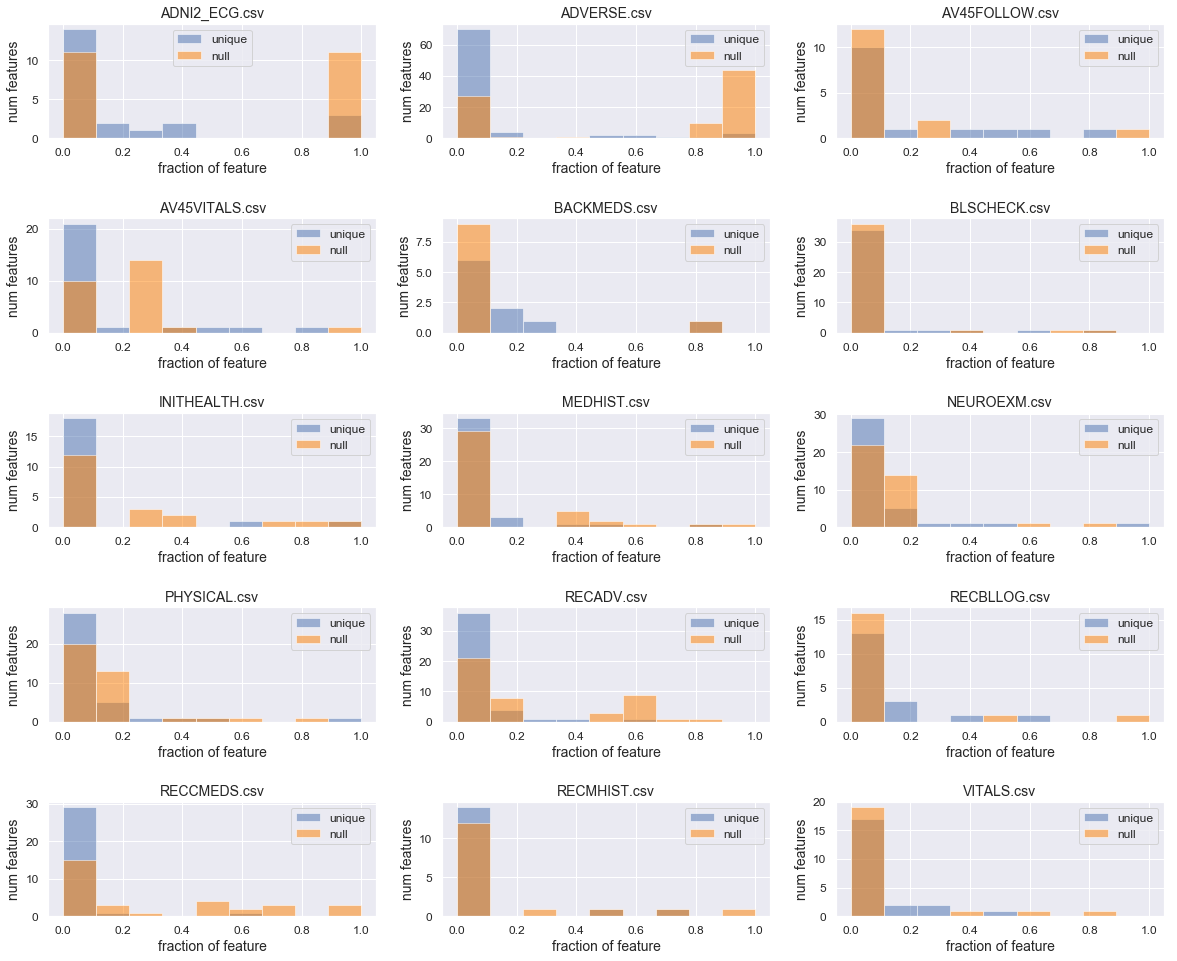

In [6]:
# get all csv files under directory
csv_paths = paths_with_ext(directory="../data/Medical_History/")
nrows = 6
ncols = np.ceil(len(csv_paths)/nrows)

plt.figure(figsize=(20,20))
# iterate over files
for i,path in enumerate(csv_paths):
    
    # initialize new plot
    plt.subplot(nrows,ncols,i+1)
    
    # read in df and record length
    df = pd.read_csv(path, low_memory=False)
    L = df.shape[0]
    
    # compute fraction of each column that is unique and fraction that is null
    frac_unique = df.apply(lambda x: x.unique().shape[0]/L)
    frac_null = df.isnull().apply(lambda x: np.sum(x)/L)
    
    # plot histograms of nullity and duplicity
    plt.hist(frac_unique, color='b', label="unique", alpha=0.5, bins=np.linspace(0,1,10))
    plt.hist(frac_null, color=(1,.5,0), label="null", alpha=0.5, bins=np.linspace(0,1,10))
    plt.legend()
    plt.xlabel("fraction of feature", FontSize=14)
    plt.ylabel("num features", FontSize=14)
    plt.title(os.path.basename(path))

plt.subplots_adjust(hspace=0.7)
plt.gcf().savefig("test.pdf")

From the above plots we can see the quite a few of the data sets are likely to have substantial nullity, including:
`ADNI2_ECG`, `ADVERSE`, `AV45VITALS`, `INITHEALTH`, and `RECCMEDS`. None of the files seem to have a substantial presence of duplicity.

## Neurological Exams

These records span all phases of ADNI and include summary results of neurological impairments including motor and cognitive deficits. Let's import that data and see what measures are recorded.

In [7]:
# intialize neuroexam results and describe entries
nex_df = pd.read_csv("../data/Medical_History/NEUROEXM.csv")

# print table summary
describe_meta_data(nex_df)

# create dictionary_df for NEUROEXM table
nex_dict = define_terms(nex_df, adni_dict_df, table_name="NEUROEXM");
nex_dict

Phases:	 ['ADNI1' 'ADNIGO' 'ADNI2' 'ADNI3']
Num Entries: 3152
Num Columns: 38
Num Patients: 2944
Records per Patient: 1-2
Phases spanned per patient: 1-2
Patients w/ Duplicates: 0


,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,NEUROEXM,Record ID,"""crfname"",""Neurological Exam"",""indexes"",""adni_..."
2,RID,N,NEUROEXM,Participant roster ID,NaN
3,SITEID,N,NEUROEXM,Site ID,NaN
4,VISCODE,T,NEUROEXM,Visit code,NaN
5,VISCODE2,T,NEUROEXM,Translated visit code,NaN
6,USERDATE,S,NEUROEXM,Date record created,NaN
7,USERDATE2,S,NEUROEXM,Date record last updated,NaN
8,EXAMDATE,D,NEUROEXM,Examination Date,NaN
9,NXVISUAL,N,NEUROEXM,1. Significant Visual Impairment,1=Absent; 2=Present


Many of the columns ending in `DES` are for doctor comments on the exams. The information in these will be hard to utilize; so we can drop them from the dataframe.

In [8]:
# drop description categories
desc_columns = [col for col in nex_df.columns if "DES" in col]
nex_df = nex_df.drop(columns=desc_columns, axis=1)

Next we should inspect the data types and make sure the format of each column makes sense.

In [9]:
# print data types for each col
nex_df.dtypes

Phase            object
ID                int64
RID               int64
SITEID            int64
VISCODE          object
VISCODE2         object
USERDATE         object
USERDATE2        object
EXAMDATE         object
NXVISUAL        float64
NXAUDITO        float64
NXTREMOR        float64
NXCONSCI        float64
NXNERVE         float64
NXMOTOR         float64
NXFINGER        float64
NXHEEL          float64
NXSENSOR        float64
NXTENDON        float64
NXPLANTA        float64
NXGAIT          float64
NXOTHER         float64
NXOTHSPE         object
NXGENCOM         object
NXABNORM        float64
update_stamp     object
dtype: object

From the list above, it looks like the measures we are interested in are the columns with dtype = `float64`. These contains diagnostic results for measurements of patient reflexes and cognition. The remaining columns all appear to be patient or visit meta data. However, it is worth noting that each of the columns with exam results essential take the form of `Normal` or `Abnormal`, which are categorical in nature. We should convert these to either boolean or integer before moving on. Before converting to `int64` we should check the format of missing values in the data. ADNI frequently uses `NaN`, `-1`, and `-4` to signify missing values.

In [10]:
# replace missing values with -1
nex_df.replace({np.nan:-1, -4:-1}, inplace=True)

# define col list with exam results
nex_cols = nex_df.columns[(nex_df.dtypes == 'float64').values]

# convert columns in list to int
nex_df[nex_cols] = nex_df[nex_cols].values.astype(int)

## Medical History

Next we'll investigate patient medical history as above. This data set includes an overview of patient medical history including phsyical and mental health as well as patient history of drug or alcohol abuse. 

In [11]:
# read in the data and print df summary
med_df = pd.read_csv("../data/Medical_History/MEDHIST.csv")
describe_meta_data(med_df)

# create dictionary_df for MEDHIST table
med_dict = define_terms(med_df, adni_dict_df, table_name="MEDHIST");
med_dict

Phases:	 ['ADNI1' 'ADNIGO' 'ADNI2']
Num Entries: 3082
Num Columns: 39
Num Patients: 2491
Records per Patient: 1-3
Phases spanned per patient: 1-3
Patients w/ Duplicates: 0


,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,MEDHIST,Record ID,"""crfname"",""Medical History"",""indexes"",""adni_me..."
2,RID,N,MEDHIST,Participant roster ID,NaN
3,SITEID,N,MEDHIST,Site ID,NaN
4,VISCODE,T,MEDHIST,Visit code,NaN
5,VISCODE2,T,MEDHIST,Translated visit code,NaN
6,USERDATE,S,MEDHIST,Date record created,NaN
7,USERDATE2,S,MEDHIST,Date record last updated,NaN
8,EXAMDATE,D,MEDHIST,Examination Date,NaN
9,MHSOURCE,N,MEDHIST,Information Source,1=Participant Visit;2=Telephone Call


From the term definitions above we can see that there are many interesting details about patient medical history such surgical history, psychiatric history, history of drug or alchohol abuse etc. These features are primarily categorical (ie. yes/no) or a discrete duration. Checking the data type of the columns reveals that the categorical variables are encoded as `int64` and durations are encoded as `float64`. The features of interest correspond to columns 10-35.

In [14]:
# inspect feature data types
med_df.dtypes

Phase            object
ID                int64
RID               int64
SITEID            int64
VISCODE          object
VISCODE2         object
USERDATE         object
USERDATE2        object
EXAMDATE         object
MHSOURCE          int64
MHPSYCH           int64
MH2NEURL          int64
MH3HEAD           int64
MH4CARD           int64
MH5RESP           int64
MH6HEPAT          int64
MH7DERM           int64
MH8MUSCL          int64
MH9ENDO           int64
MH10GAST          int64
MH11HEMA          int64
MH12RENA          int64
MH13ALLE          int64
MH14ALCH          int64
MH14AALCH       float64
MH14BALCH       float64
MH14CALCH       float64
MH15DRUG          int64
MH15ADRUG       float64
MH15BDRUG       float64
MH16SMOK          int64
MH16ASMOK       float64
MH16BSMOK       float64
MH16CSMOK       float64
MH17MALI          int64
MH18SURG          int64
MH19OTHR          int64
MHCOMMEN         object
update_stamp     object
dtype: object

In [12]:


# record the columns of interest
med_cols = med_df.columns[10:36]

To handle missingness, we'll enforce all missing values to be `-1`.

In [12]:
# set nan and -4 to -1
med_df.replace({np.nan:-1, -4:-1}, inplace=True)

## Baseline Symptoms / Initial Health

The names of `BLSCHECK` and `INITHEALTH` and the phases covered by each file suggest that these files contain the same type of information but for different phases. Let's see if they can be easily combined by looking at the features in each.

**INITHEALTH**

In [13]:
# read in the data and print df summary
init_df = pd.read_csv("../data/Medical_History/INITHEALTH.csv")
describe_meta_data(init_df)

# create dictionary_df for MEDHIST table
init_dict = define_terms(init_df, adni_dict_df, table_name="INITHEALTH");
init_dict

Phases:	 ['ADNI3']
Num Entries: 10432
Num Columns: 20
Num Patients: 893
Records per Patient: 1-60
Phases spanned per patient: 1-1
Patients w/ Duplicates: 864


,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,INITHEALTH,NaN,NaN
2,RID,N,INITHEALTH,NaN,NaN
3,SITEID,N,INITHEALTH,NaN,NaN
4,VISCODE,T,INITHEALTH,NaN,NaN
5,USERDATE,S,INITHEALTH,NaN,NaN
6,USERDATE2,S,INITHEALTH,NaN,NaN
7,IHNUM,N,INITHEALTH,Condition Number,NaN
8,IHSYMPTOM,N,INITHEALTH,System/Category,1=Psychiatric;2=Neurologic (other than Cogniti...
9,IHDESC,T,INITHEALTH,Description/Condition,NaN


**BLSCHECK**

In [14]:
# read in the data and print df summary
bls_df = pd.read_csv("../data/Medical_History/BLSCHECK.csv")
describe_meta_data(bls_df)

# create dictionary_df for MEDHIST table
bls_dict = define_terms(bls_df, adni_dict_df, table_name="BLSCHECK");
bls_dict

Phases:	 ['ADNI1' 'ADNIGO' 'ADNI2']
Num Entries: 2549
Num Columns: 39
Num Patients: 2153
Records per Patient: 1-3
Phases spanned per patient: 1-2
Patients w/ Duplicates: 10


,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,BLSCHECK,Record ID,"""crfname"",""Baseline Symptoms Checklist"",""index..."
2,RID,N,BLSCHECK,Participant roster ID,NaN
3,SITEID,N,BLSCHECK,Site ID,NaN
4,VISCODE,T,BLSCHECK,Visit code,NaN
5,VISCODE2,T,BLSCHECK,Translated visit code,NaN
6,USERDATE,S,BLSCHECK,Date record created,NaN
7,USERDATE2,S,BLSCHECK,Date record last updated,NaN
8,EXAMDATE,D,BLSCHECK,Examination Date,NaN
9,BCNAUSEA,N,BLSCHECK,1. Nausea,1=Absent; 2=Present


The column names make it pretty clear that these do not contain the same information. The `BLSCHECK` data set seems relatively comprehensive in terms of patient over all health. It covers a lot of patients and covers most of the ADNI phases. The symptom columns correspond to columns 9-35. We should record these for later use and ensure that the data types are all `int64` (these measures are all binary) and that the missing value is set to `-1`.

In [15]:
# record bls columns
bls_cols = bls_df.columns[9:36]

# set missing value
bls_df.replace({np.nan:-1, -4:-1}, inplace=True)

# check data type
bls_df[bls_cols].dtypes.unique()

array([dtype('float64')], dtype=object)

In [16]:
# convert data type from float to int
bls_df[bls_cols] = bls_df[bls_cols].values.astype(int)

## PATIENT VITAL SIGNS

These data points contain a lot of measurements across time. A quick and dirty approach is to compute patient averages, although this fails to capture any information about how the measurements change across time for each patient. We could also create additional metrics that capture some of this information (eg. avg change per unit time)

In [17]:
# import data and get dictionary
vitals_df = pd.read_csv("../data/Medical_History/VITALS.csv")
vitals_dict = define_terms(vitals_df, adni_dict_df, table_name = "VITALS")
vitals_dict

,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,VITALS,Record ID,"""crfname"",""Vital Signs"",""indexes"",""adni_vitals..."
2,RID,N,VITALS,Participant roster ID,NaN
3,SITEID,N,VITALS,Site ID,NaN
4,VISCODE,T,VITALS,Visit code,NaN
5,VISCODE2,T,VITALS,Translated visit code,NaN
6,USERDATE,S,VITALS,Date record created,NaN
7,USERDATE2,S,VITALS,Date record last updated,NaN
8,EXAMDATE,D,VITALS,Examination Date,NaN
9,VSWEIGHT,N,VITALS,1a. Weight,NaN


The patient vitals signs are contained in columns `9-19`. We can see from the column descriptions that some of these contain the units that vitals measurents were recorded in. We should convert all units to metric standard and drop the columns containing units information.

We can define a function to convert units.

In [18]:
# scales units in the specified columns by the values specified in a conversion dictionary {unit_type: conversion_factor}
def normalize_units(df, data_cols, unit_cols, conv_dicts):
    # df - dataframe containing data with unit listings
    # data_cols - df columns containing data to be converted
    # unit_cols - df columns containing unit keys
    # conv_dict - list of dictionaries specifying unit key: unit conversion factor
    
    # iterate over columns to perform units conversions on
    for i, col in enumerate(data_cols):
        
        # grab values and iterate over units to normalize
        v = df[col].values
        u = df[unit_cols[i]].values
        for key in conv_dicts[i]:
            v[u==key] = v[u==key] * conv_dicts[i][key]
            
        # update dataframe
        df[col] = v
        
    return(df)

In [19]:
# define conversion dictionaries for [weight, height, temp] units
conv = [{1: 0.453592, 2: 1}, {1: 2.54, 2: 1}, {1: (5/9), 2: 1}]

# convert lbs to kg, inches to cm
vitals_df = normalize_units(vitals_df, ["VSWEIGHT","VSHEIGHT","VSTEMP"], ["VSWTUNIT","VSHTUNIT","VSTMPUNT"], conv)
vitals_df["VSTEMP"] = vitals_df["VSTEMP"] - (32*(5/9))

With the units standardized, we can record the columns to keep and ensure that all columns have data type `float64` with standard missing value of `-1`.

In [20]:
# columns to keep
vitals_cols = ["VSWEIGHT","VSHEIGHT","VSBPSYS","VSBPDIA","VSPULSE","VSRESP","VSTEMP"]

# ensure standard missing units
vitals_df.replace({np.nan:-1, -4:-1}, inplace=True)

vitals_df[vitals_cols].dtypes.unique()

array([dtype('float64')], dtype=object)

## Save cleaned medical history file

With the columns from each data set hand-picked, the appropriate data types selected, and the missingness standardized, we can write the new cleaned dataframes to file.

In [21]:
# intialize dataframe list and empty placeholder
all_dfs = [nex_df, med_df, bls_df, vitals_df]
all_df_cols = [nex_cols, med_cols, bls_cols, vitals_cols]
df_names = ["neuroexams","medhist","blsymptoms","vitals"]

# iterate over dataframes
for i,df in enumerate(all_dfs):
    
    # ensure RID is in column list for indexing
    cols = all_df_cols[i]
    cols = append_meta_cols(df.columns, cols)
    
    # write data to csv
    to_write = df[cols]
    to_write.to_csv("../data/Cleaned/" + df_names[i] + "_clean.csv")